## Imports

In [1]:
import sys, pdb, os, json, random
import numpy as np
import tensorflow as tf
sess = tf.Session()

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Random seed has to come before Keras imports
np.random.seed(1337) #stay 1337 AF
tf.set_random_seed(1337)
random.seed(1337)

from keras import backend as K
K.set_session(sess)

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Add the parent directory to PYTHONPATH so that we can use utils.py
sys.path.append('../scripts')
import utils

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Vector Embeddings

In [2]:
d = 50 #dimensionality of word vectors
data = utils.build_word_vector_matrix('../ChessEmbeddings/data/embeddings/vectors_d{}.txt'.format(d))
embeddings, labels, id_to_move, move_to_id = data

## Load Chess Moves Dataset

In [3]:
def decode_games(encoded_games, embeddings, id_to_move, deminsions):
    
    zeros = np.zeros((200, deminsions))
    encoded_moves = []
    
    for state in encoded_games:
        match_found = False
        for vec in reversed(state):
            if not (vec == zeros).all():
                encoded_moves.append(vec)
                match_found = True
                break
        if not match_found:
            encoded_moves.append(-1)
    
    decoded = []
    for enc in encoded_moves:
        if type(enc) == int and enc == -1:
            decoded.append(' ')
        else: 
            for i, embedding in enumerate(embeddings):
                if (enc == embedding).all():
                    decoded.append(i)
                    break
    
    to_moves = []
    for d in decoded:
        if d == ' ':
            to_moves.append(d)
        else:
            to_moves.append(id_to_move[d])
            
    return to_moves

X_train, y_train, X_test, y_test, _, _ = utils.load_data('../ChessEmbeddings/data/test_moves.txt', 
                                                         embeddings, 
                                                         move_to_id, 
                                                         dimensions=d)
# decoded = decode_games(X_train[0:200], embeddings, id_to_move, 50)
# decoded.pop(0) # remove the very first move (it's blank)

X_train, y_train = utils.preprocess(X_train, y_train)
X_test, y_test   = utils.preprocess(X_test, y_test)

unknown move g5#
unknown move Rgxd2
unknown move b4#
unknown move Rgxh6


In [4]:
# One-hot encoding
uniq_labels = list(move_to_id.values())

## Preprocessing and Data Prep

In [5]:
def labels_to_ints(labels):
    ints = []
    for label in labels:
        if label in move_to_id:
            ints.append(move_to_id[label])
        else:
            ints.append(-1)
    return ints

y_train = np.asarray(labels_to_ints(y_train))
y_test  = np.asarray(labels_to_ints(y_test))

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

In [6]:
y_train = to_categorical(y_train, len(uniq_labels))
y_test = to_categorical(y_test, len(uniq_labels))

## Create or Load Model

In [7]:
hyper = {
    'layers': [{
        'units': 4096,
        'init': 'normal',
        'activation': 'relu',
        'dropout': 0.5
        },
        {
        'units': len(uniq_labels),
        'init': 'normal',
        'activation': 'sigmoid'
    }],
    'loss': 'categorical_crossentropy',
    'optimizer': {
        'type': 'rmsprop',
        'lr': 0.0001
    },
    'metrics': ['accuracy']

}

model_num = 1
model_dir = '../data/models/nn/{}'.format(model_num)

## Create new model, or...
model, callbacks = utils.create_model(X_train.shape[1], 
                                      len(uniq_labels), 
                                      save_dir=model_dir,
                                      hyper=hyper,
                                      verbose=False)

# Load from checkpoint
# model = utils.load_model_from_checkpoint('../ChessEmbeddings/data/models/nn/' + str(model_num))

## Load from a checkpoint, but change loss or optimization
# model = utils.load_model_from_checkpoint('../data/models/' + str(model_num), compile=False)
# optimizer = RMSprop(lr=0.00001)
# model.compile(loss=hyper['loss'], optimizer=optimizer, metrics=hyper['metrics'])

## Model Callbacks

In [8]:
# early stopping
# min_delta = the mininum change in the monitored metric before waiting $patience turns before stopping
# patience = how many consecutive epochs $val_loss change < min_delta before stopping

# callbacks.append(EarlyStopping(monitor='val_loss', 
#                                min_delta=0.001,  
#                                patience=3, 
#                                verbose=1, 
#                                mode='auto'))

## Train the Model

In [9]:
history = model.fit(X_train, 
                    y_train, 
                    nb_epoch=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks,
                    verbose=1)

Train on 9989 samples, validate on 1456 samples
Epoch 1/10
9989/9989 [==============================] - 10s - loss: 8.8755 - acc: 0.0227 - val_loss: 7.4117 - val_acc: 0.0323
Epoch 2/10
9989/9989 [==============================] - 10s - loss: 6.4820 - acc: 0.0398 - val_loss: 6.9993 - val_acc: 0.0391
Epoch 3/10
9989/9989 [==============================] - 10s - loss: 5.6050 - acc: 0.0632 - val_loss: 6.9509 - val_acc: 0.0598
Epoch 4/10
9989/9989 [==============================] - 10s - loss: 5.0563 - acc: 0.0848 - val_loss: 6.9939 - val_acc: 0.0618
Epoch 5/10
9989/9989 [==============================] - 10s - loss: 4.6518 - acc: 0.1034 - val_loss: 7.0640 - val_acc: 0.0639
Epoch 6/10
9989/9989 [==============================] - 10s - loss: 4.3510 - acc: 0.1157 - val_loss: 7.1134 - val_acc: 0.0652
Epoch 7/10
9989/9989 [==============================] - 10s - loss: 4.1123 - acc: 0.1280 - val_loss: 7.1665 - val_acc: 0.0673
Epoch 8/10
9989/9989 [==============================] - 10s - loss: 3.

## Evaluate and Plot the Model

acc 0.0707417582418
loss 7.30996975532


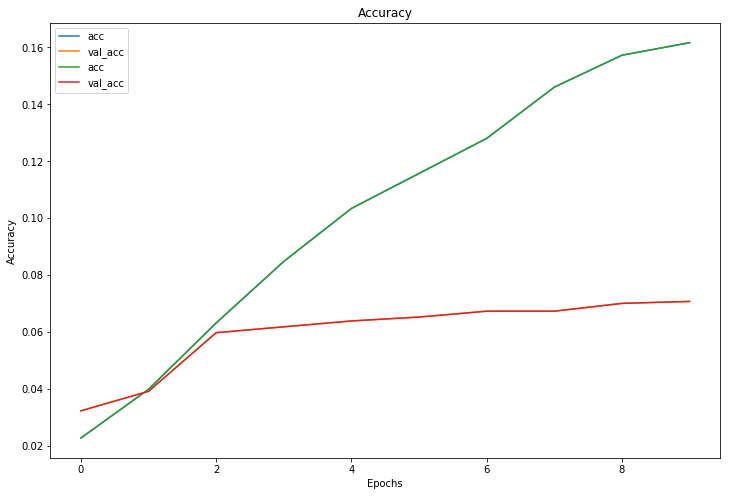

Highest val_acc at epoch 10 with value of 0.071


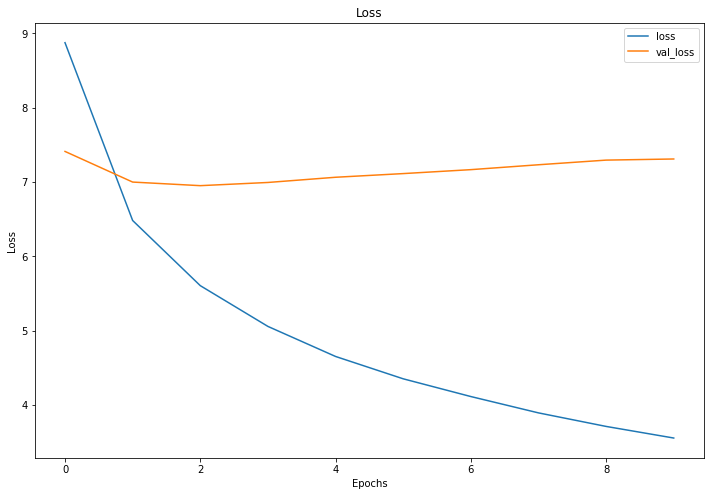

Lowest val_loss at epoch 3 with value of 6.95


In [11]:
metrics = model.evaluate(X_test, y_test, verbose=0)
metrics = dict(zip(model.metrics_names, metrics))
for k, v in metrics.items():
    print(k, v)
    
# Saves png graphs to savedir
utils.plot_model_results(history, save_dir=model_dir)    

## Predict and Test

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 4096)          40964096    dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4096)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 3469)          14212493    dropout_1[0][0]                  
Total params: 55,176,589
Trainable params: 55,176,589
Non-trainable params: 0
____________________________________________________________________________________________________


In [13]:
predicted = model.predict(X_train)
ids = [np.argmax(p) for p in predicted]
moves = [id_to_move[i] for i in ids]

In [14]:
moves

['e4',
 'Nf6',
 'Nf3',
 'Nf3',
 'Rc8',
 'Nf3',
 'Nf3',
 'a3',
 'Qd3',
 'Qd3',
 'Qd3',
 'Bxf6',
 'Bxf6',
 'Be5',
 'Bxf6',
 'Bxf6',
 'Bxf6',
 'Qh7+',
 'Qh7+',
 'Qh7+',
 'Rxd4',
 'Rxd4',
 'Rxd4',
 'Rxd4',
 'Bxd4',
 'Qxh6+',
 'Qxh6+',
 'Bxd5',
 'Bxd5',
 'Rxe8+',
 'Qxe8',
 'Qxe8',
 'Qxe8',
 'Qxe8',
 'Qxe8',
 'Bxa3',
 'Bxa3',
 'Bxf2+',
 'Bxf2+',
 'Bxf2+',
 'Bxf2+',
 'Bxf2+',
 'Bxf2+',
 'Bxf2+',
 '1/2-1/2',
 'e4',
 'c5',
 'Nf3',
 'Nc6',
 'd4',
 'cxd4',
 'Nxd4',
 'Nf6',
 'Nc3',
 'Nc3',
 'Nc3',
 'e5',
 'O-O',
 'Be7',
 'Be7',
 'Nf6',
 'Be7',
 'Bxf6',
 'Bxf6',
 'Bxf6',
 'Bxf6',
 'Bxf6',
 'Bxf6',
 'Nd5',
 'Nd5',
 'Nd5',
 'Nd5',
 'Bxf6',
 'O-O',
 'O-O',
 'O-O',
 'Ne7',
 'Rc8',
 'Rc8',
 'Nxd5',
 'Nxd5',
 'Nxd5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc5',
 'Bxd3',
 'Qxd3',
 'Qxd3',
 'Qxd3',
 'Rc5',
 'Rc5',
 'Rc5',
 'Rc1',
 'Rc1',
 'Rc1',
 'Rec2',
 'Rec2',
 'Rec2',
 'Rec2',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'Qg3',
 'f3